In [1]:
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd 

import importlib 

import simulation 
import utils

import copy

''' 
Compare different simulations ---- 3.2.1 (critical vs. base learning from AI)
'''

In [2]:
base_params_dict = {
    "N": 1000, # Population size
    # "u": 0.01, # Environmental change rate
    "u": 0.0001,
    "c_I": 0.05, # Cost of individual learning
    "c_AI": 0.0, # Cost of AI update
    "z": 0.66, # Success rate of individual learning
    "s0": 0.85, # Survival probability (non-adapted)
    "s1": 0.93, # Survival probability (adapted)
    "phi": 1., # AI bias parameter
    "epsilon_I": 0.0,  # Social learning error rate for humans
    "epsilon_AI": 0.0, # Social learning error rate for AI
    "mu": 0.005, # Mutation rate
    "n_records": 200000, # Number of steps to average over
    "social_learning_mode": "both", # Who can agents socially learn from: "", "human", "ai", "both"
    "resignation": False, 
    "resignation_hint": 1,
    "ai_individ_learn": False,
    "critical": False, # Is critical social learning enabled
    "ind_penalty_mult": 1., # How much is individual learning probability multiplied by after learning from AI
    "learn_twice": False, # Should agent have second opportunity to learn if first one fails (only one of critical and learn_twice should be on at a time)
    "sim_name": "base" # Name of current simulation (will be used in figure filenames)
}

In [3]:
params_dict_local_base = copy.copy(base_params_dict) 
params_dict_local_base['social_learning_mode'] = 'ai'
params_dict_local_base['sim_name'] = 'sec_3_1_2_override'
params_dict_local_base['n_records'] = 1000

critical_vary = [False, True]
world_change_rates = {'slow': 0.01, 'moderate': 0.1, 'fast': 0.5}
importlib.reload(utils)

score_data = {
    'critical': [], 
    'u': [],
    'ai_bias': [],
    'score': [],
    'timestep': []
}

all_scores = []
for allow_critical in critical_vary: 
    scores = []
    for world_change, world_change_rate in world_change_rates.items(): 
        params_dict = copy.copy(params_dict_local_base)
        params_dict['u'] = world_change_rate
        params_dict['critical'] = allow_critical
    

        social_learner_freqs, ai_bias_means, change_points, ai_adaptation, learner_adaptation, social_learner_adaptation = simulation.run_simulation(
            N=params_dict["N"], n_generations=params_dict["n_records"], u=params_dict["u"], c_I=params_dict["c_I"], c_AI=params_dict["c_AI"],
            z=params_dict["z"], s0=params_dict["s0"], s1=params_dict["s1"], phi=params_dict["phi"], epsilon_I=params_dict["epsilon_I"], mu=params_dict["mu"], n_records=params_dict["n_records"],
            social_learning_mode=params_dict["social_learning_mode"], critical=params_dict["critical"], ind_penalty_mult=params_dict["ind_penalty_mult"], learn_twice=params_dict["learn_twice"]
        )
        scores.append(learner_adaptation)#np.mean(learner_adaptation))
        
        for t, score in enumerate(learner_adaptation): 
            score_data['critical'].append(allow_critical)
            score_data['u'].append(world_change),
            score_data['score'].append(score)
            score_data['timestep'].append(t)
            score_data['ai_bias'].append(ai_bias_means[t]/ai_bias_means[t]+1)
        
        
    all_scores.append(scores)
df = pd.DataFrame.from_dict(score_data)

# utils.plot_results(params_dict, social_learner_freqs, ai_bias_means, change_points, ai_adaptation, learner_adaptation, social_learner_adaptation)
# print(np.mean(learner_adaptation))

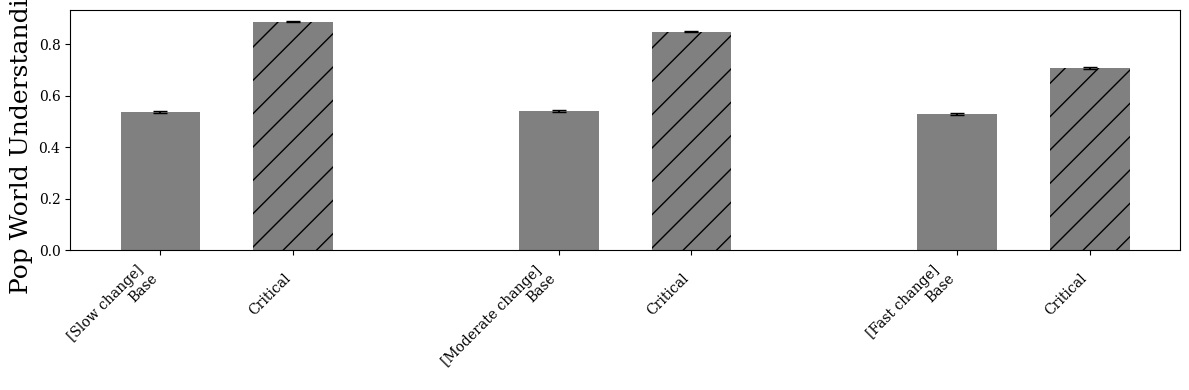

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams['font.family'] = 'serif'
# Set style
sns.set_palette("husl")

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 4))

soft_grey = '#808080'    # Soft grey
soft_maroon = '#800000'  # Soft maroon

# Create barplot for each u value and critical state
positions = np.array([1, 2, 4, 5, 7, 8])  # Positions for bars with gaps between u groups
labels = []

for i, u in enumerate(world_change_rates):
    # Filter data for each u value
    u_data = df[df['u'] == u]
    
    # Calculate means for False and True critical states
    mean_false = u_data[u_data['critical'] == False]['score'].mean()
    mean_true = u_data[u_data['critical'] == True]['score'].mean()
    
    # Calculate standard errors
    se_false = u_data[u_data['critical'] == False]['score'].std() / np.sqrt(len(u_data[u_data['critical'] == False]))
    se_true = u_data[u_data['critical'] == True]['score'].std() / np.sqrt(len(u_data[u_data['critical'] == True]))
    
    # Create bars
    ax.bar(positions[i*2], mean_false, width=0.6, yerr=se_false, capsize=5, color=soft_grey, 
           error_kw={'capthick': 1, 'elinewidth': 1.5})
    ax.bar(positions[i*2 + 1], mean_true, width=0.6, yerr=se_true, capsize=5, color=soft_grey, hatch='/',
           error_kw={'capthick': 1, 'elinewidth': 1.5})
    
    labels.extend([f'[{u.capitalize()} change] \nBase', f'\nCritical'])

# Customize plot
ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Pop World Understanding', fontsize=18)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()
plt.savefig("crit_compare_change.pdf", dpi=400)
plt.close()

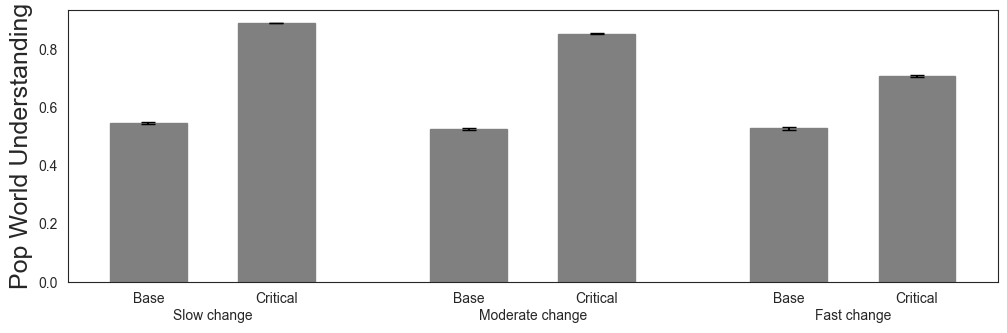

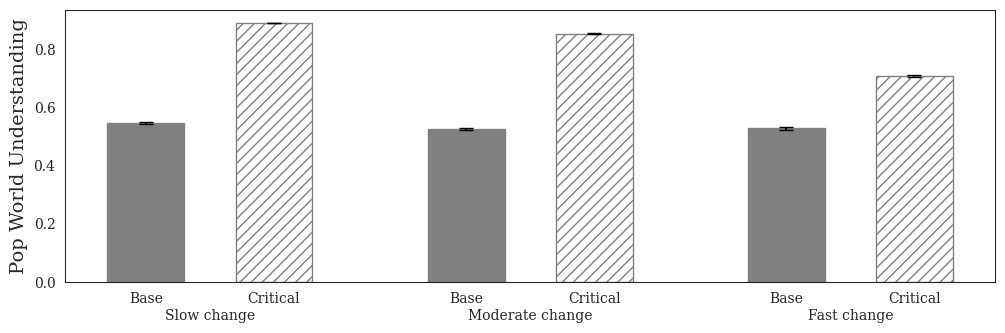

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams['font.family'] = 'serif'
# Set style
sns.set_style("white")

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 4))
grey_color = '#808080'

# Create barplot for each u value and critical state
positions = np.array([1, 2, 3.5, 4.5, 6, 7])  # Reduced gaps between groups
base_labels = ['Base', 'Critical']
change_labels = ['Slow change', 'Moderate change', 'Fast change']

for i, u in enumerate(world_change_rates):
    # Filter data for each u value
    u_data = df[df['u'] == u]
    
    # Calculate means and standard errors
    mean_false = u_data[u_data['critical'] == False]['score'].mean()
    mean_true = u_data[u_data['critical'] == True]['score'].mean()
    se_false = u_data[u_data['critical'] == False]['score'].std() / np.sqrt(len(u_data[u_data['critical'] == False]))
    se_true = u_data[u_data['critical'] == True]['score'].std() / np.sqrt(len(u_data[u_data['critical'] == True]))
    
    # Create bars - base bars solid, critical bars hatched
    ax.bar(positions[i*2], mean_false, width=0.6, yerr=se_false, capsize=5,
           color=grey_color, edgecolor=grey_color,
           error_kw={'capthick': 1, 'elinewidth': 1.5})
    ax.bar(positions[i*2 + 1], mean_true, width=0.6, yerr=se_true, capsize=5,
           color='white', edgecolor=grey_color, hatch='///',  # Added back hatching
           error_kw={'capthick': 1, 'elinewidth': 1.5})

# Set x-ticks and labels with serif font
ax.set_xticks(positions)
ax.set_xticklabels(['Base', 'Critical'] * 3, fontfamily='serif')

# Add change type labels below with serif font
for i, label in enumerate(change_labels):
    mid_point = (positions[i*2] + positions[i*2 + 1]) / 2
    ax.text(mid_point, -0.1, label, ha='center', va='top', 
            transform=ax.get_xaxis_transform(), fontfamily='serif')

ax.set_ylabel('Pop World Understanding', fontsize=14, fontfamily='serif')

# Make sure all tick labels use serif font
plt.setp(ax.get_xticklabels(), fontfamily='serif')
plt.setp(ax.get_yticklabels(), fontfamily='serif')

# Adjust layout
plt.subplots_adjust(bottom=0.2)  # Make room for bottom labels
plt.savefig("crit_compare_change.pdf", dpi=400, bbox_inches='tight')
plt.show()
plt.close()